<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/LSTM_%EC%B9%BC%EB%A7%8C%ED%95%84%ED%84%B0_%EC%85%801%EB%B2%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
forecasting = 20

In [129]:
import os
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from keras.layers import RNN
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.layers.core import Activation, Dense, Dropout
from keras import layers, models
from sklearn import preprocessing
from keras import datasets
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import model_selection

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [132]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

In [133]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [134]:
A = 1
H = 1
Q = 0.00001
R = 0.001

x_0 = df[0]
P_0 = 1

In [135]:
n_samples = len(df)

In [136]:
x_esti, P = None, None
esti_save = np.zeros(n_samples)

In [137]:
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(df[i], x_esti, P)
        
    esti_save[i] = x_esti

Text(0, 0.5, 'Voltage [V]')

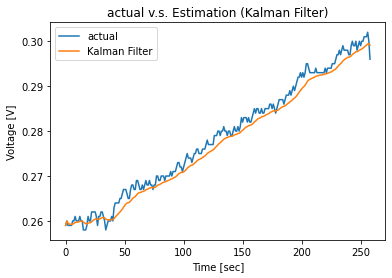

In [138]:
plt.plot(df, label='actual')
plt.plot(esti_save, label='Kalman Filter')
plt.legend(loc='upper left')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

In [139]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [140]:
x_train = esti_save
y_train = esti_save

In [141]:
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

In [142]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

In [143]:
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

In [144]:
lookback = len(df)
print(lookback)
train_feature, train_label = make_dataset(x_train, y_train, lookback-1)
train_feature.shape


259


(1, 258, 1)

In [145]:
model = Sequential()
model.add(LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dropout(0.1))
model.add(Dense(1))

In [146]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [147]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
h = model.fit(train_feature, train_label, 
                    epochs=500, 
                    batch_size=1, verbose=2)

Epoch 1/500
1/1 - 1s - loss: 1.1733 - mse: 1.1733
Epoch 2/500
1/1 - 0s - loss: 1.1209 - mse: 1.1209
Epoch 3/500
1/1 - 0s - loss: 1.1952 - mse: 1.1952
Epoch 4/500
1/1 - 0s - loss: 1.1796 - mse: 1.1796
Epoch 5/500
1/1 - 0s - loss: 1.1365 - mse: 1.1365
Epoch 6/500
1/1 - 0s - loss: 1.1488 - mse: 1.1488
Epoch 7/500
1/1 - 0s - loss: 1.1340 - mse: 1.1340
Epoch 8/500
1/1 - 0s - loss: 1.0319 - mse: 1.0319
Epoch 9/500
1/1 - 0s - loss: 1.1052 - mse: 1.1052
Epoch 10/500
1/1 - 0s - loss: 1.0926 - mse: 1.0926
Epoch 11/500
1/1 - 0s - loss: 1.0587 - mse: 1.0587
Epoch 12/500
1/1 - 0s - loss: 1.0644 - mse: 1.0644
Epoch 13/500
1/1 - 0s - loss: 1.0511 - mse: 1.0511
Epoch 14/500
1/1 - 0s - loss: 1.0219 - mse: 1.0219
Epoch 15/500
1/1 - 0s - loss: 0.9729 - mse: 0.9729
Epoch 16/500
1/1 - 0s - loss: 0.9621 - mse: 0.9621
Epoch 17/500
1/1 - 0s - loss: 0.9513 - mse: 0.9513
Epoch 18/500
1/1 - 0s - loss: 1.0206 - mse: 1.0206
Epoch 19/500
1/1 - 0s - loss: 0.9762 - mse: 0.9762
Epoch 20/500
1/1 - 0s - loss: 0.9649 - m

In [148]:
error_select=[]

오차율 =  [0.64139355]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Unrecognized location 'upper ajleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0, 0.5, 'Voltage [V]')

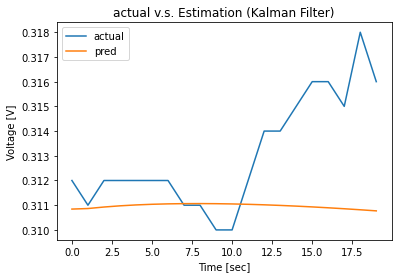

In [149]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

test_df = test_df['Resistance']

n_samples = len(test_df)
test_df_re = test_df[:n_samples-forecasting]

x_esti, P = None, None
esti_save = np.zeros(n_samples-forecasting)
# print(test_df_re)

for i in range(n_samples-forecasting):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_df_re[i], x_esti, P)
        
    esti_save[i] = x_esti

x_train = esti_save
y_train = esti_save

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

train_feature, train_label = make_dataset(x_train, y_train, n_samples-forecasting-1)
# print(train_feature)
look_ahead=forecasting
xhat = train_feature[0]
predictions = np.zeros((look_ahead, 1))


for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("xhat = ", xhat)
  # print("predddd = ", prediction)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print("aa = ",len(predictions))
# print(predictions)

pred = scaler.inverse_transform(predictions)



actual = test_df[n_samples-forecasting:].values
# print(actual)
for i in range(forecasting):
    error_avg = 0
    error = abs((actual[i]-pred[i])/ actual[i]*100)
    error_avg = error_avg + error
print("오차율 = ",(error_avg/n_samples)*100)
error_select.append((error_avg/n_samples)*100)

plt.plot(actual, label='actual')
plt.plot(pred, label='pred')
plt.legend(loc='upper ajleft')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

오차율 =  [2.72250467]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Unrecognized location 'upper ajleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0, 0.5, 'Voltage [V]')

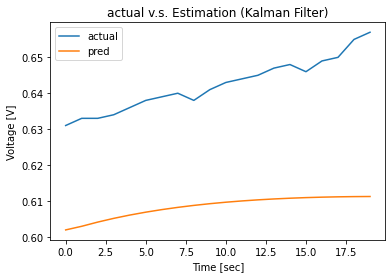

In [150]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

test_df = test_df['Resistance']

n_samples = len(test_df)
test_df_re = test_df[:n_samples-forecasting]

x_esti, P = None, None
esti_save = np.zeros(n_samples-forecasting)
# print(test_df_re)

for i in range(n_samples-forecasting):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_df_re[i], x_esti, P)
        
    esti_save[i] = x_esti

x_train = esti_save
y_train = esti_save

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

train_feature, train_label = make_dataset(x_train, y_train, n_samples-forecasting-1)
# print(train_feature)
look_ahead=forecasting
xhat = train_feature[0]
predictions = np.zeros((look_ahead, 1))


for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("xhat = ", xhat)
  # print("predddd = ", prediction)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print("aa = ",len(predictions))
# print(predictions)

pred = scaler.inverse_transform(predictions)



actual = test_df[n_samples-forecasting:].values
# print(actual)
for i in range(forecasting):
    error_avg = 0
    error = abs((actual[i]-pred[i])/ actual[i]*100)
    error_avg = error_avg + error
print("오차율 = ",(error_avg/n_samples)*100)
error_select.append((error_avg/n_samples)*100)

plt.plot(actual, label='actual')
plt.plot(pred, label='pred')
plt.legend(loc='upper ajleft')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

오차율 =  [5.27737187]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Unrecognized location 'upper ajleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0, 0.5, 'Voltage [V]')

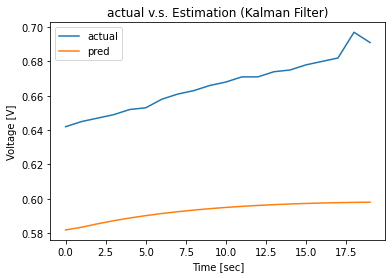

In [151]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

test_df = test_df['Resistance']

n_samples = len(test_df)
test_df_re = test_df[:n_samples-forecasting]

x_esti, P = None, None
esti_save = np.zeros(n_samples-forecasting)
# print(test_df_re)

for i in range(n_samples-forecasting):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_df_re[i], x_esti, P)
        
    esti_save[i] = x_esti

x_train = esti_save
y_train = esti_save

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

train_feature, train_label = make_dataset(x_train, y_train, n_samples-forecasting-1)
# print(train_feature)
look_ahead=forecasting
xhat = train_feature[0]
predictions = np.zeros((look_ahead, 1))


for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("xhat = ", xhat)
  # print("predddd = ", prediction)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print("aa = ",len(predictions))
# print(predictions)

pred = scaler.inverse_transform(predictions)



actual = test_df[n_samples-forecasting:].values
# print(actual)
for i in range(forecasting):
    error_avg = 0
    error = abs((actual[i]-pred[i])/ actual[i]*100)
    error_avg = error_avg + error
print("오차율 = ",(error_avg/n_samples)*100)
error_select.append((error_avg/n_samples)*100)

plt.plot(actual, label='actual')
plt.plot(pred, label='pred')
plt.legend(loc='upper ajleft')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

오차율 =  [2.57818798]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Unrecognized location 'upper ajleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0, 0.5, 'Voltage [V]')

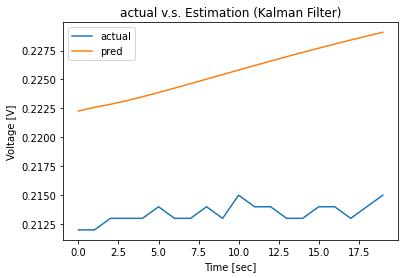

In [152]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

test_df = test_df['Resistance']

n_samples = len(test_df)
test_df_re = test_df[:n_samples-forecasting]

x_esti, P = None, None
esti_save = np.zeros(n_samples-forecasting)
# print(test_df_re)

for i in range(n_samples-forecasting):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_df_re[i], x_esti, P)
        
    esti_save[i] = x_esti

x_train = esti_save
y_train = esti_save

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

train_feature, train_label = make_dataset(x_train, y_train, n_samples-forecasting-1)
# print(train_feature)
look_ahead=forecasting
xhat = train_feature[0]
predictions = np.zeros((look_ahead, 1))


for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("xhat = ", xhat)
  # print("predddd = ", prediction)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print("aa = ",len(predictions))
# print(predictions)

pred = scaler.inverse_transform(predictions)



actual = test_df[n_samples-forecasting:].values
# print(actual)
for i in range(forecasting):
    error_avg = 0
    error = abs((actual[i]-pred[i])/ actual[i]*100)
    error_avg = error_avg + error
print("오차율 = ",(error_avg/n_samples)*100)
error_select.append((error_avg/n_samples)*100)

plt.plot(actual, label='actual')
plt.plot(pred, label='pred')
plt.legend(loc='upper ajleft')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

오차율 =  [1.72888456]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Unrecognized location 'upper ajleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0, 0.5, 'Voltage [V]')

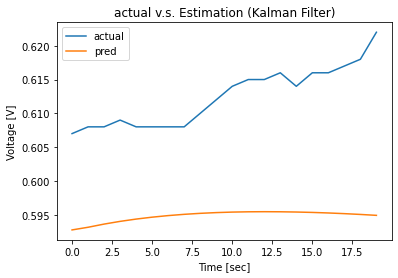

In [153]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

test_df = test_df['Resistance']

n_samples = len(test_df)
test_df_re = test_df[:n_samples-forecasting]

x_esti, P = None, None
esti_save = np.zeros(n_samples-forecasting)
# print(test_df_re)

for i in range(n_samples-forecasting):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_df_re[i], x_esti, P)
        
    esti_save[i] = x_esti

x_train = esti_save
y_train = esti_save

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

train_feature, train_label = make_dataset(x_train, y_train, n_samples-forecasting-1)
# print(train_feature)
look_ahead=forecasting
xhat = train_feature[0]
predictions = np.zeros((look_ahead, 1))


for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("xhat = ", xhat)
  # print("predddd = ", prediction)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print("aa = ",len(predictions))
# print(predictions)

pred = scaler.inverse_transform(predictions)



actual = test_df[n_samples-forecasting:].values
# print(actual)
for i in range(forecasting):
    error_avg = 0
    error = abs((actual[i]-pred[i])/ actual[i]*100)
    error_avg = error_avg + error
print("오차율 = ",(error_avg/n_samples)*100)
error_select.append((error_avg/n_samples)*100)

plt.plot(actual, label='actual')
plt.plot(pred, label='pred')
plt.legend(loc='upper ajleft')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

오차율 =  [0.78155083]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Unrecognized location 'upper ajleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0, 0.5, 'Voltage [V]')

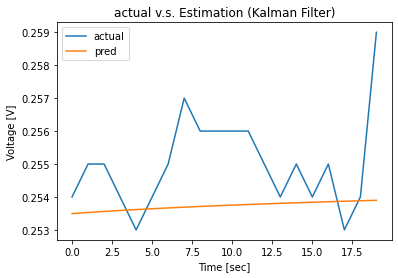

In [154]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

test_df = test_df['Resistance']

n_samples = len(test_df)
test_df_re = test_df[:n_samples-forecasting]

x_esti, P = None, None
esti_save = np.zeros(n_samples-forecasting)
# print(test_df_re)

for i in range(n_samples-forecasting):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_df_re[i], x_esti, P)
        
    esti_save[i] = x_esti

x_train = esti_save
y_train = esti_save

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

train_feature, train_label = make_dataset(x_train, y_train, n_samples-forecasting-1)
# print(train_feature)
look_ahead=forecasting
xhat = train_feature[0]
predictions = np.zeros((look_ahead, 1))


for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("xhat = ", xhat)
  # print("predddd = ", prediction)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print("aa = ",len(predictions))
# print(predictions)

pred = scaler.inverse_transform(predictions)



actual = test_df[n_samples-forecasting:].values
# print(actual)
for i in range(forecasting):
    error_avg = 0
    error = abs((actual[i]-pred[i])/ actual[i]*100)
    error_avg = error_avg + error
print("오차율 = ",(error_avg/n_samples)*100)
error_select.append((error_avg/n_samples)*100)

plt.plot(actual, label='actual')
plt.plot(pred, label='pred')
plt.legend(loc='upper ajleft')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

오차율 =  [0.53523363]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Unrecognized location 'upper ajleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0, 0.5, 'Voltage [V]')

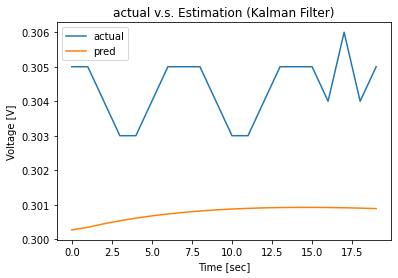

In [155]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

test_df = test_df['Resistance']

n_samples = len(test_df)
test_df_re = test_df[:n_samples-forecasting]

x_esti, P = None, None
esti_save = np.zeros(n_samples-forecasting)
# print(test_df_re)

for i in range(n_samples-forecasting):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_df_re[i], x_esti, P)
        
    esti_save[i] = x_esti

x_train = esti_save
y_train = esti_save

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

train_feature, train_label = make_dataset(x_train, y_train, n_samples-forecasting-1)
# print(train_feature)
look_ahead=forecasting
xhat = train_feature[0]
predictions = np.zeros((look_ahead, 1))


for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("xhat = ", xhat)
  # print("predddd = ", prediction)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print("aa = ",len(predictions))
# print(predictions)

pred = scaler.inverse_transform(predictions)



actual = test_df[n_samples-forecasting:].values
# print(actual)
for i in range(forecasting):
    error_avg = 0
    error = abs((actual[i]-pred[i])/ actual[i]*100)
    error_avg = error_avg + error
print("오차율 = ",(error_avg/n_samples)*100)
error_select.append((error_avg/n_samples)*100)

plt.plot(actual, label='actual')
plt.plot(pred, label='pred')
plt.legend(loc='upper ajleft')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

오차율 =  [0.46072935]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Unrecognized location 'upper ajleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0, 0.5, 'Voltage [V]')

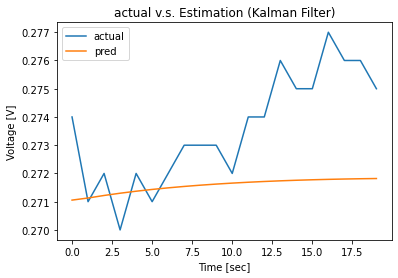

In [156]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

test_df = test_df['Resistance']

n_samples = len(test_df)
test_df_re = test_df[:n_samples-forecasting]

x_esti, P = None, None
esti_save = np.zeros(n_samples-forecasting)
# print(test_df_re)

for i in range(n_samples-forecasting):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_df_re[i], x_esti, P)
        
    esti_save[i] = x_esti

x_train = esti_save
y_train = esti_save

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

train_feature, train_label = make_dataset(x_train, y_train, n_samples-forecasting-1)
# print(train_feature)
look_ahead=forecasting
xhat = train_feature[0]
predictions = np.zeros((look_ahead, 1))


for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("xhat = ", xhat)
  # print("predddd = ", prediction)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print("aa = ",len(predictions))
# print(predictions)

pred = scaler.inverse_transform(predictions)



actual = test_df[n_samples-forecasting:].values
# print(actual)
for i in range(forecasting):
    error_avg = 0
    error = abs((actual[i]-pred[i])/ actual[i]*100)
    error_avg = error_avg + error
print("오차율 = ",(error_avg/n_samples)*100)
error_select.append((error_avg/n_samples)*100)

plt.plot(actual, label='actual')
plt.plot(pred, label='pred')
plt.legend(loc='upper ajleft')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

오차율 =  [3.13313175]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Unrecognized location 'upper ajleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0, 0.5, 'Voltage [V]')

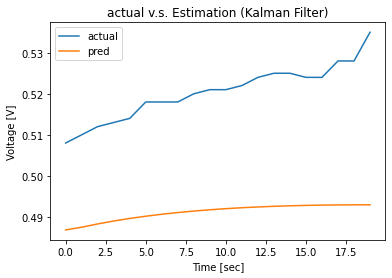

In [158]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

test_df = test_df['Resistance']

n_samples = len(test_df)
test_df_re = test_df[:n_samples-forecasting]

x_esti, P = None, None
esti_save = np.zeros(n_samples-forecasting)
# print(test_df_re)

for i in range(n_samples-forecasting):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_df_re[i], x_esti, P)
        
    esti_save[i] = x_esti

x_train = esti_save
y_train = esti_save

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

train_feature, train_label = make_dataset(x_train, y_train, n_samples-forecasting-1)
# print(train_feature)
look_ahead=forecasting
xhat = train_feature[0]
predictions = np.zeros((look_ahead, 1))


for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("xhat = ", xhat)
  # print("predddd = ", prediction)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print("aa = ",len(predictions))
# print(predictions)

pred = scaler.inverse_transform(predictions)



actual = test_df[n_samples-forecasting:].values
# print(actual)
for i in range(forecasting):
    error_avg = 0
    error = abs((actual[i]-pred[i])/ actual[i]*100)
    error_avg = error_avg + error
print("오차율 = ",(error_avg/n_samples)*100)
error_select.append((error_avg/n_samples)*100)

plt.plot(actual, label='actual')
plt.plot(pred, label='pred')
plt.legend(loc='upper ajleft')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

In [159]:
error_select

[array([0.64139355]),
 array([2.72250467]),
 array([5.27737187]),
 array([2.57818798]),
 array([1.72888456]),
 array([0.78155083]),
 array([0.53523363]),
 array([0.46072935]),
 array([3.13313175])]